In [1]:
! pwd

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing/TSMO


In [2]:
%cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data_processing


In [3]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import math

from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import *

In [4]:
# Hyper-parameters 

# Round up to 5 decimal place to avoid mismatch due to mathematical precision
round_decimals = pd.Series(data=5, index=['start_latitude','start_longitude', 'end_latitude', 'end_longitude'])

# Range of neighborhood
range = 5

## 1. Get Upstream and Downstream TMC Segments

1. Select TMC 
2. Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions
    - If there is multiple prev or next, store as a list
3. Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next
    - If there is multiple prev or next, the endpoint is a splitting point, we should split into several results 

### 1.1 Load TMC Segments from Geo Data

In [5]:
# TMC Shapefile
gdf_shp_tmc = gpd.read_file("../data/shape/tmc_shape_TSMO/tmc_shape_TSMO_for_sjoin.geojson")  # id and geometry of 1591 unique tmc segments in TSMO shape file, shape (1591, 18) 
gdf_shp_tmc = gdf_shp_tmc.rename(columns={"tmc":"id_tmc"})
gdf_shp_tmc = gdf_shp_tmc.round(decimals=round_decimals)  # round up to 5 decimal place to avoid mismatch due to mathematical precision, e.g. I missed "104-06225" and "104-06224" previously due to unaligned mathematical precisions.

set_shp_tmc_segments = set(gdf_shp_tmc.id_tmc) # 1591 TMC segments covered in shapefile

<AxesSubplot: title={'center': 'Visualization of 1591 TSMO TMC Segments (orange)'}>

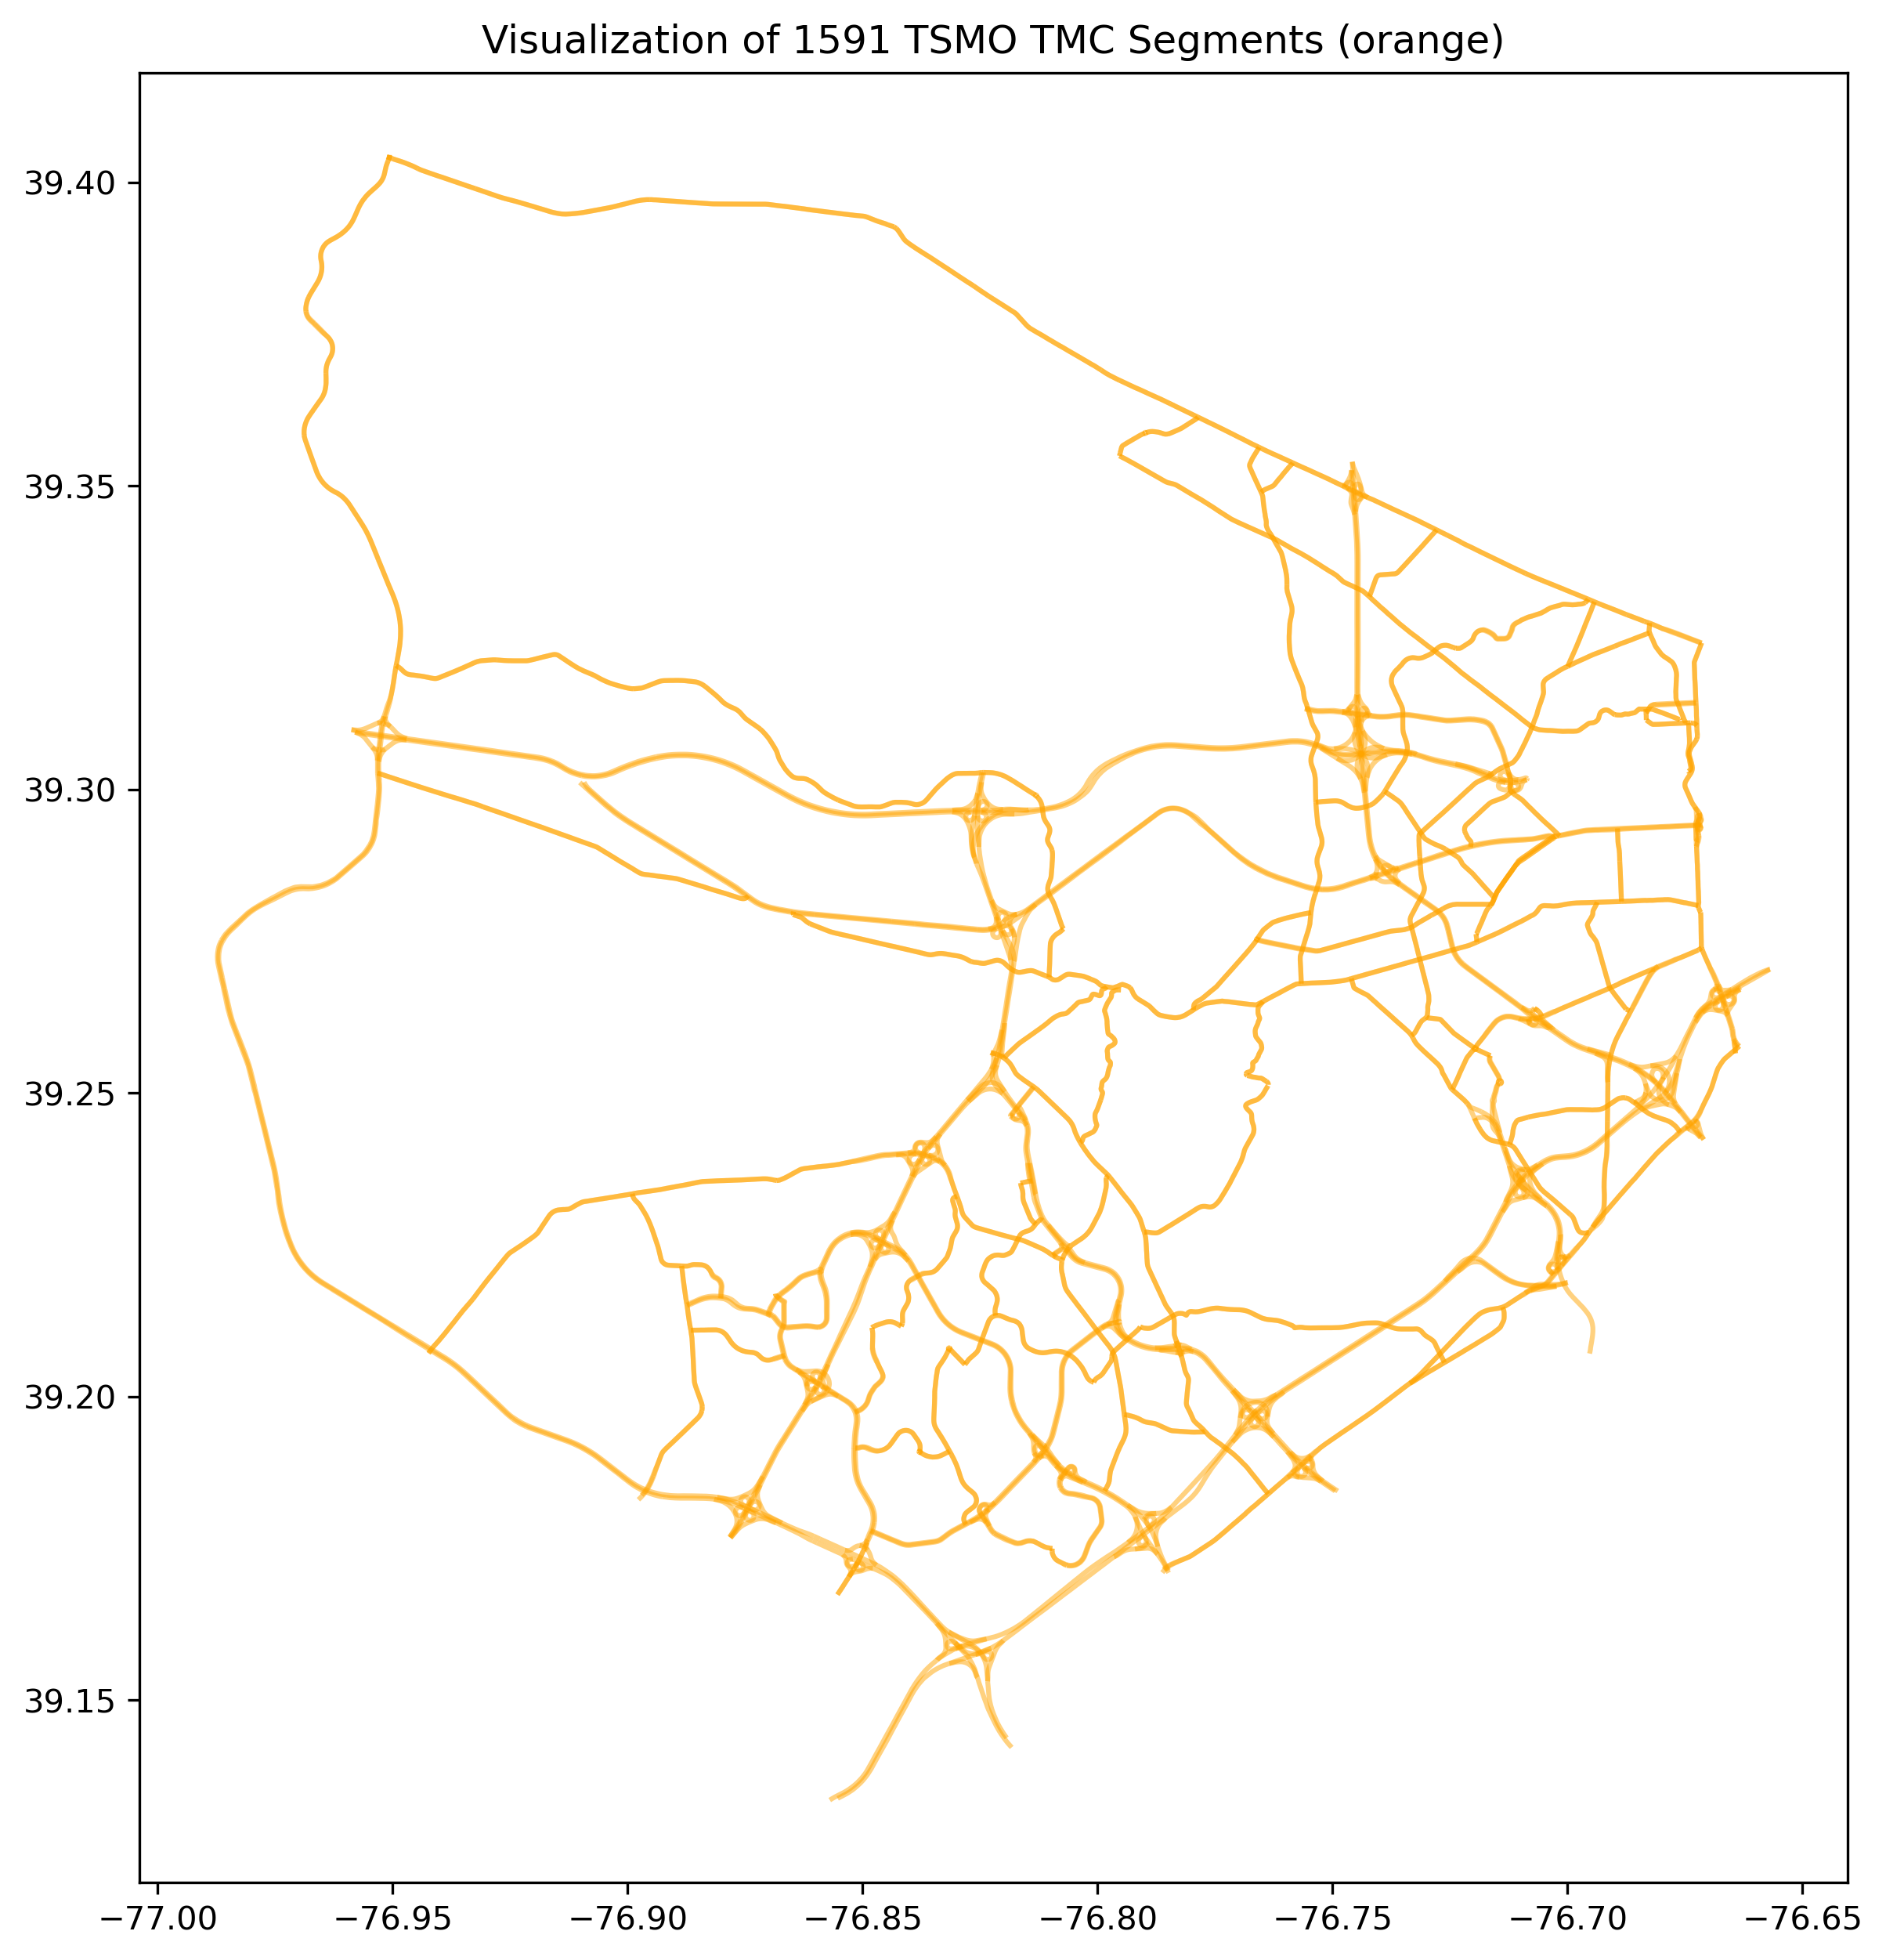

In [6]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of 1591 TSMO TMC Segments (orange)")
gdf_shp_tmc.plot(ax=ax, color="orange", alpha=0.5)

In [7]:
dict_miles_tmc = dict(gdf_shp_tmc[["id_tmc", "miles"]].values)

In [8]:
pickle.dump(dict_miles_tmc, open("./TSMO/TSMO_dict_miles_tmc_for_upstream.pkl", "wb"))

### 1.2 Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions

#### 1.2.1 Previous Segment

In [9]:
# Step 1. Join starting and ending positions
df_raw_prev_tmc_1591 = pd.merge(left=gdf_shp_tmc, right=gdf_shp_tmc, left_on=["start_latitude", "start_longitude"], right_on=["end_latitude", "end_longitude"], how="left") # includes 1591 starting TMC segments matched with 1493 prev neighbors, shape (2797, 36)
df_raw_prev_tmc = df_raw_prev_tmc_1591[~df_raw_prev_tmc_1591.id_tmc_y.isna()]  # includes 1483 starting TMC segments matched with 1492 prev neighbors, shape (2689, 36)

In [10]:
# It's noted that entries in "direction" column is not "clean"
# We will take care of them in manual checking of direction/angle.
df_raw_prev_tmc.direction_x.unique()  

array(['SOUTHBOUND', 'WESTBOUND', 'COUNTERCLOCKWISE', 'I-95 NORTHBOUND',
       'I-70/US-40/BALTIMORE NATIONAL PIKE WESTBOUND',
       'US-1-ALT/S CANTON AVE NORTHBOUND', 'I-95 SOUTHBOUND',
       'US-1-ALT/S CANTON AVE NORTHBOUND/US-1-ALT/S CANTON AVE NORTHBOUND',
       'US-1-ALT/S CANTON AVE NORTHBOUND AND I-95 NORTHBOUND',
       'US-1-ALT/S CANTON AVE SOUTHBOUND/US-1-ALT/S CANTON AVE SOUTHBOUND',
       'US-1-ALT/S CANTON AVE', 'MD-175/WATERLOO RD EASTBOUND',
       'MD-175/WATERLOO RD WESTBOUND', 'MD-175/WATERLOO RD', 'EASTBOUND',
       'NORTHBOUND', 'MD-175/LITTLE PATUXENT PKWY WESTBOUND',
       'SNOWDEN RIVER PKWY', 'MD-175/PATUXENT PKWY EASTBOUND',
       'MD-175/PATUXENT PKWY EASTBOUND AND COLUMBIA GATEWAY DR SB/MD-175/PATUXENT PKWY EASTBOUND AND COLUMBIA GATEWAY DR SB',
       'SNOWDEN RIVER PKWY NORTHBOUND', 'SNOWDEN RIVER PKWY SOUTHBOUND',
       'SNOWDEN RIVER PKWY AND COLUMBIA GATEWAY DR SOUTHBOUND',
       'COLUMBIA GATEWAY DR SOUTHBOUND', 'MD-175/PATUXENT PKWY WESTBO

In [11]:
# Step 2. Compute angle  
df_raw_prev_tmc["angle"] = df_raw_prev_tmc.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_19197/600702446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_prev_tmc["angle"] = df_raw_prev_tmc.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)


In [12]:
# summary of angle
df_raw_prev_tmc.angle.describe()

count    2689.000000
mean        0.379625
std         0.425477
min         0.000000
25%         0.012431
50%         0.083378
75%         1.000000
max         1.000000
Name: angle, dtype: float64

In [13]:
df_raw_prev_tmc_checked_angle = df_raw_prev_tmc[df_raw_prev_tmc.angle < 0.75] # 1439 starting TMC segments, (1902, 33)

In [14]:
# summary of angle
df_raw_prev_tmc_checked_angle.angle.describe()

count    1902.000000
mean        0.127045
std         0.192947
min         0.000000
25%         0.007656
50%         0.026419
75%         0.121725
max         0.736558
Name: angle, dtype: float64

<AxesSubplot: title={'center': 'Visualization of 1591 TSMO TMC Segments, 1439 of which is covered in df_raw_prev_tmc_checked_angle'}>

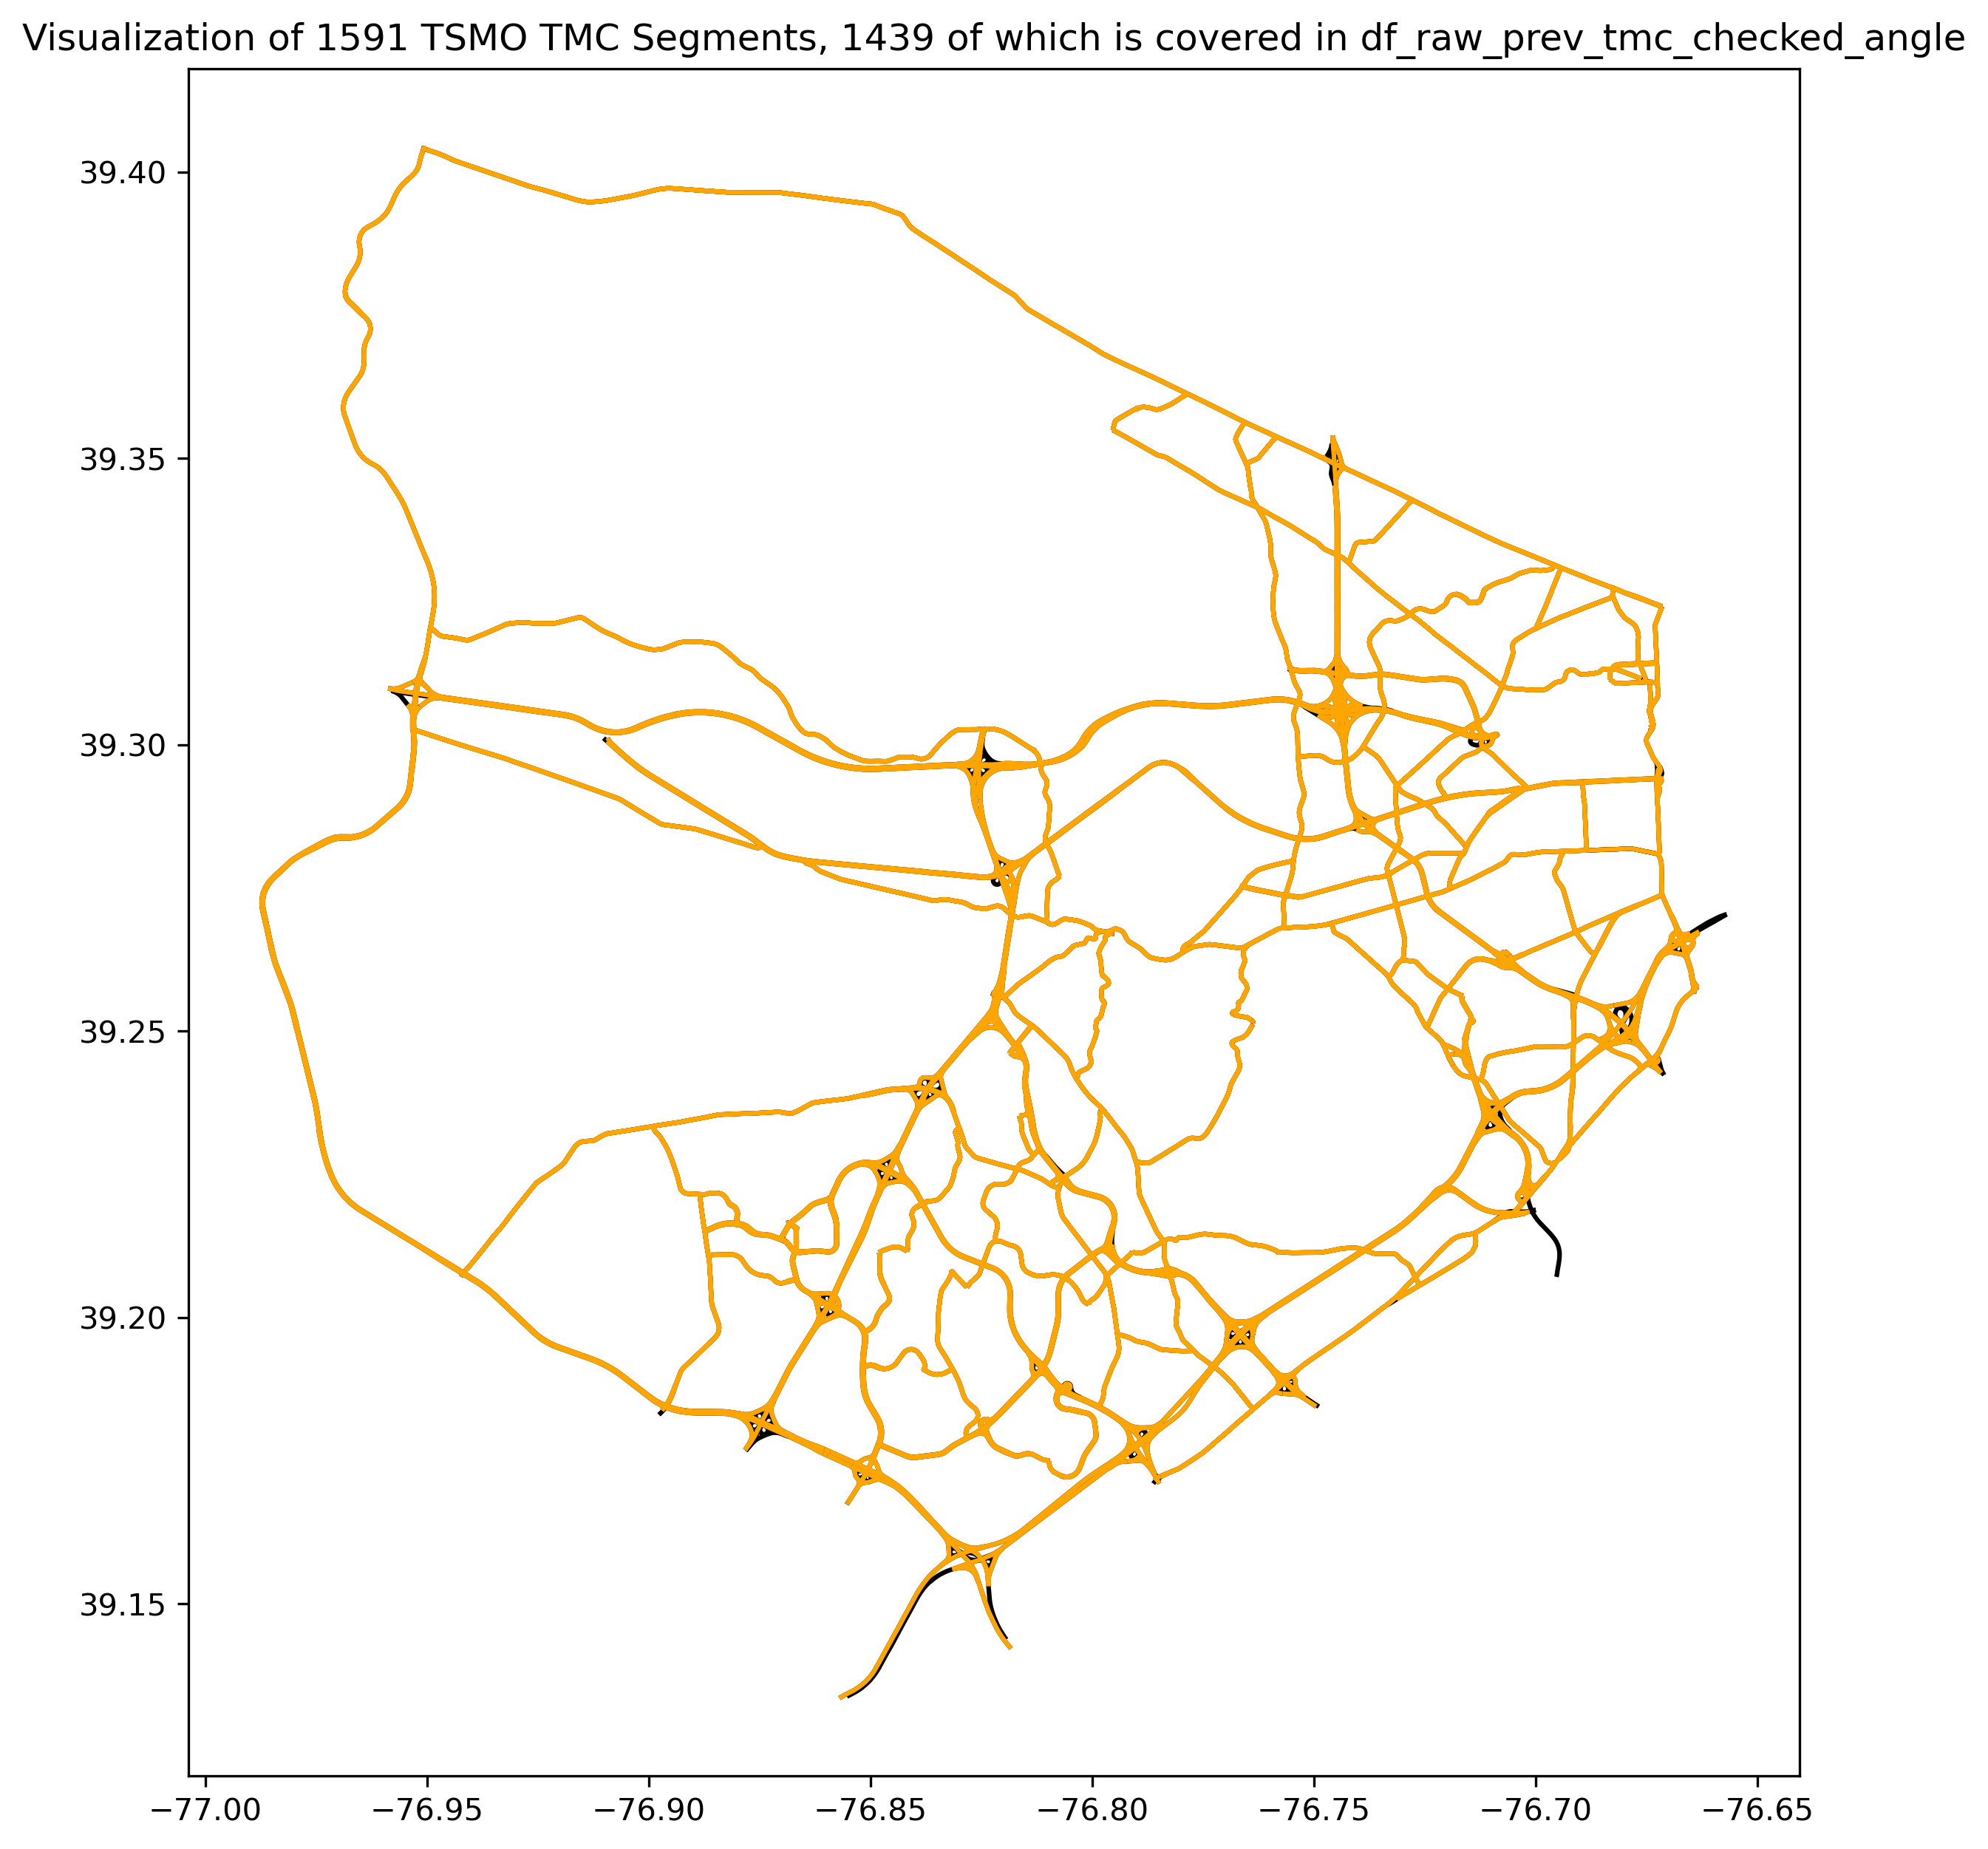

In [15]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title("Visualization of 1591 TSMO TMC Segments, 1433 of which is covered in df_raw_prev_tmc_checked_angle")
gdf_shp_tmc.plot(ax=ax, color="black")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(df_raw_prev_tmc_checked_angle.id_tmc_x)].plot(ax=ax, color="orange")

In [16]:
# Step 3. output raw csv file for manual checking
df_raw_prev_tmc_checked_angle.sort_values(by="id_tmc_x").to_csv("./TSMO/TSMO_raw_prev_tmc.csv", index=False)  # 1902 pairs, 518 of which have angle > 0.1

# I have decided not to auto-check direction, but manually chceck directions, as there are cases where neighbors can have opposite directions.
# df_raw_prev_tmc["direction_matchness"] = df_raw_prev_tmc.apply(lambda x: check_direction(x.direction_x, x.direction_y), axis=1)
# df_raw_prev_tmc = df_raw_prev_tmc[df_raw_prev_tmc.direction_matchness == 1].reset_index(drop=True) # includes 884 TMC segments, shape (1131, 34) 

In [17]:
# Step 4. Load manually checked immediate previous segments
df_prev_tmc = pd.read_csv("./TSMO/TSMO_prev_tmc.csv")
df_prev_tmc = df_prev_tmc[["id_tmc_x", "id_tmc_y"]].groupby("id_tmc_x").agg(tuple).applymap(list).reset_index()
df_prev_tmc.columns = ["id_tmc", "prev_tmc"] # shape (1433, 2)

In [18]:
df_prev_tmc_multiple = df_prev_tmc[df_prev_tmc.prev_tmc.map(len) > 1]  # there are 396 TMC segments which have more than one immediate neighbors

In [19]:
df_prev_tmc_multiple

,id_tmc,prev_tmc
0,110+04384,"[110P15117, 110P04383]"
1,110+04385,"[110P55499, 110P04384]"
3,110+04387,"[110P04386, 110P15291]"
7,110+04409,"[110P55281, 110P04408]"
8,110+04410,"[110P15109, 110P04409]"
...,...,...
1409,110P55669,"[110P55662, 110P55660]"
1417,110P55687,"[110P55685, 110P55683]"
1419,110P55693,"[110P55689, 110P55691]"
1426,110P57066,"[110P57068, 110P57070]"


In [20]:
# Convert dataframe to dictionary to be saved later
dict_prev_tmc = dict(df_prev_tmc.values) # contains 1433 tmc segments, 396 of which have more than one immediate prev neighbor

<AxesSubplot: title={'center': "Visualization of 1591 TSMO TMC Segments, where 1433 (blue) have prev neighbors and 158 segment (red) don't"}>

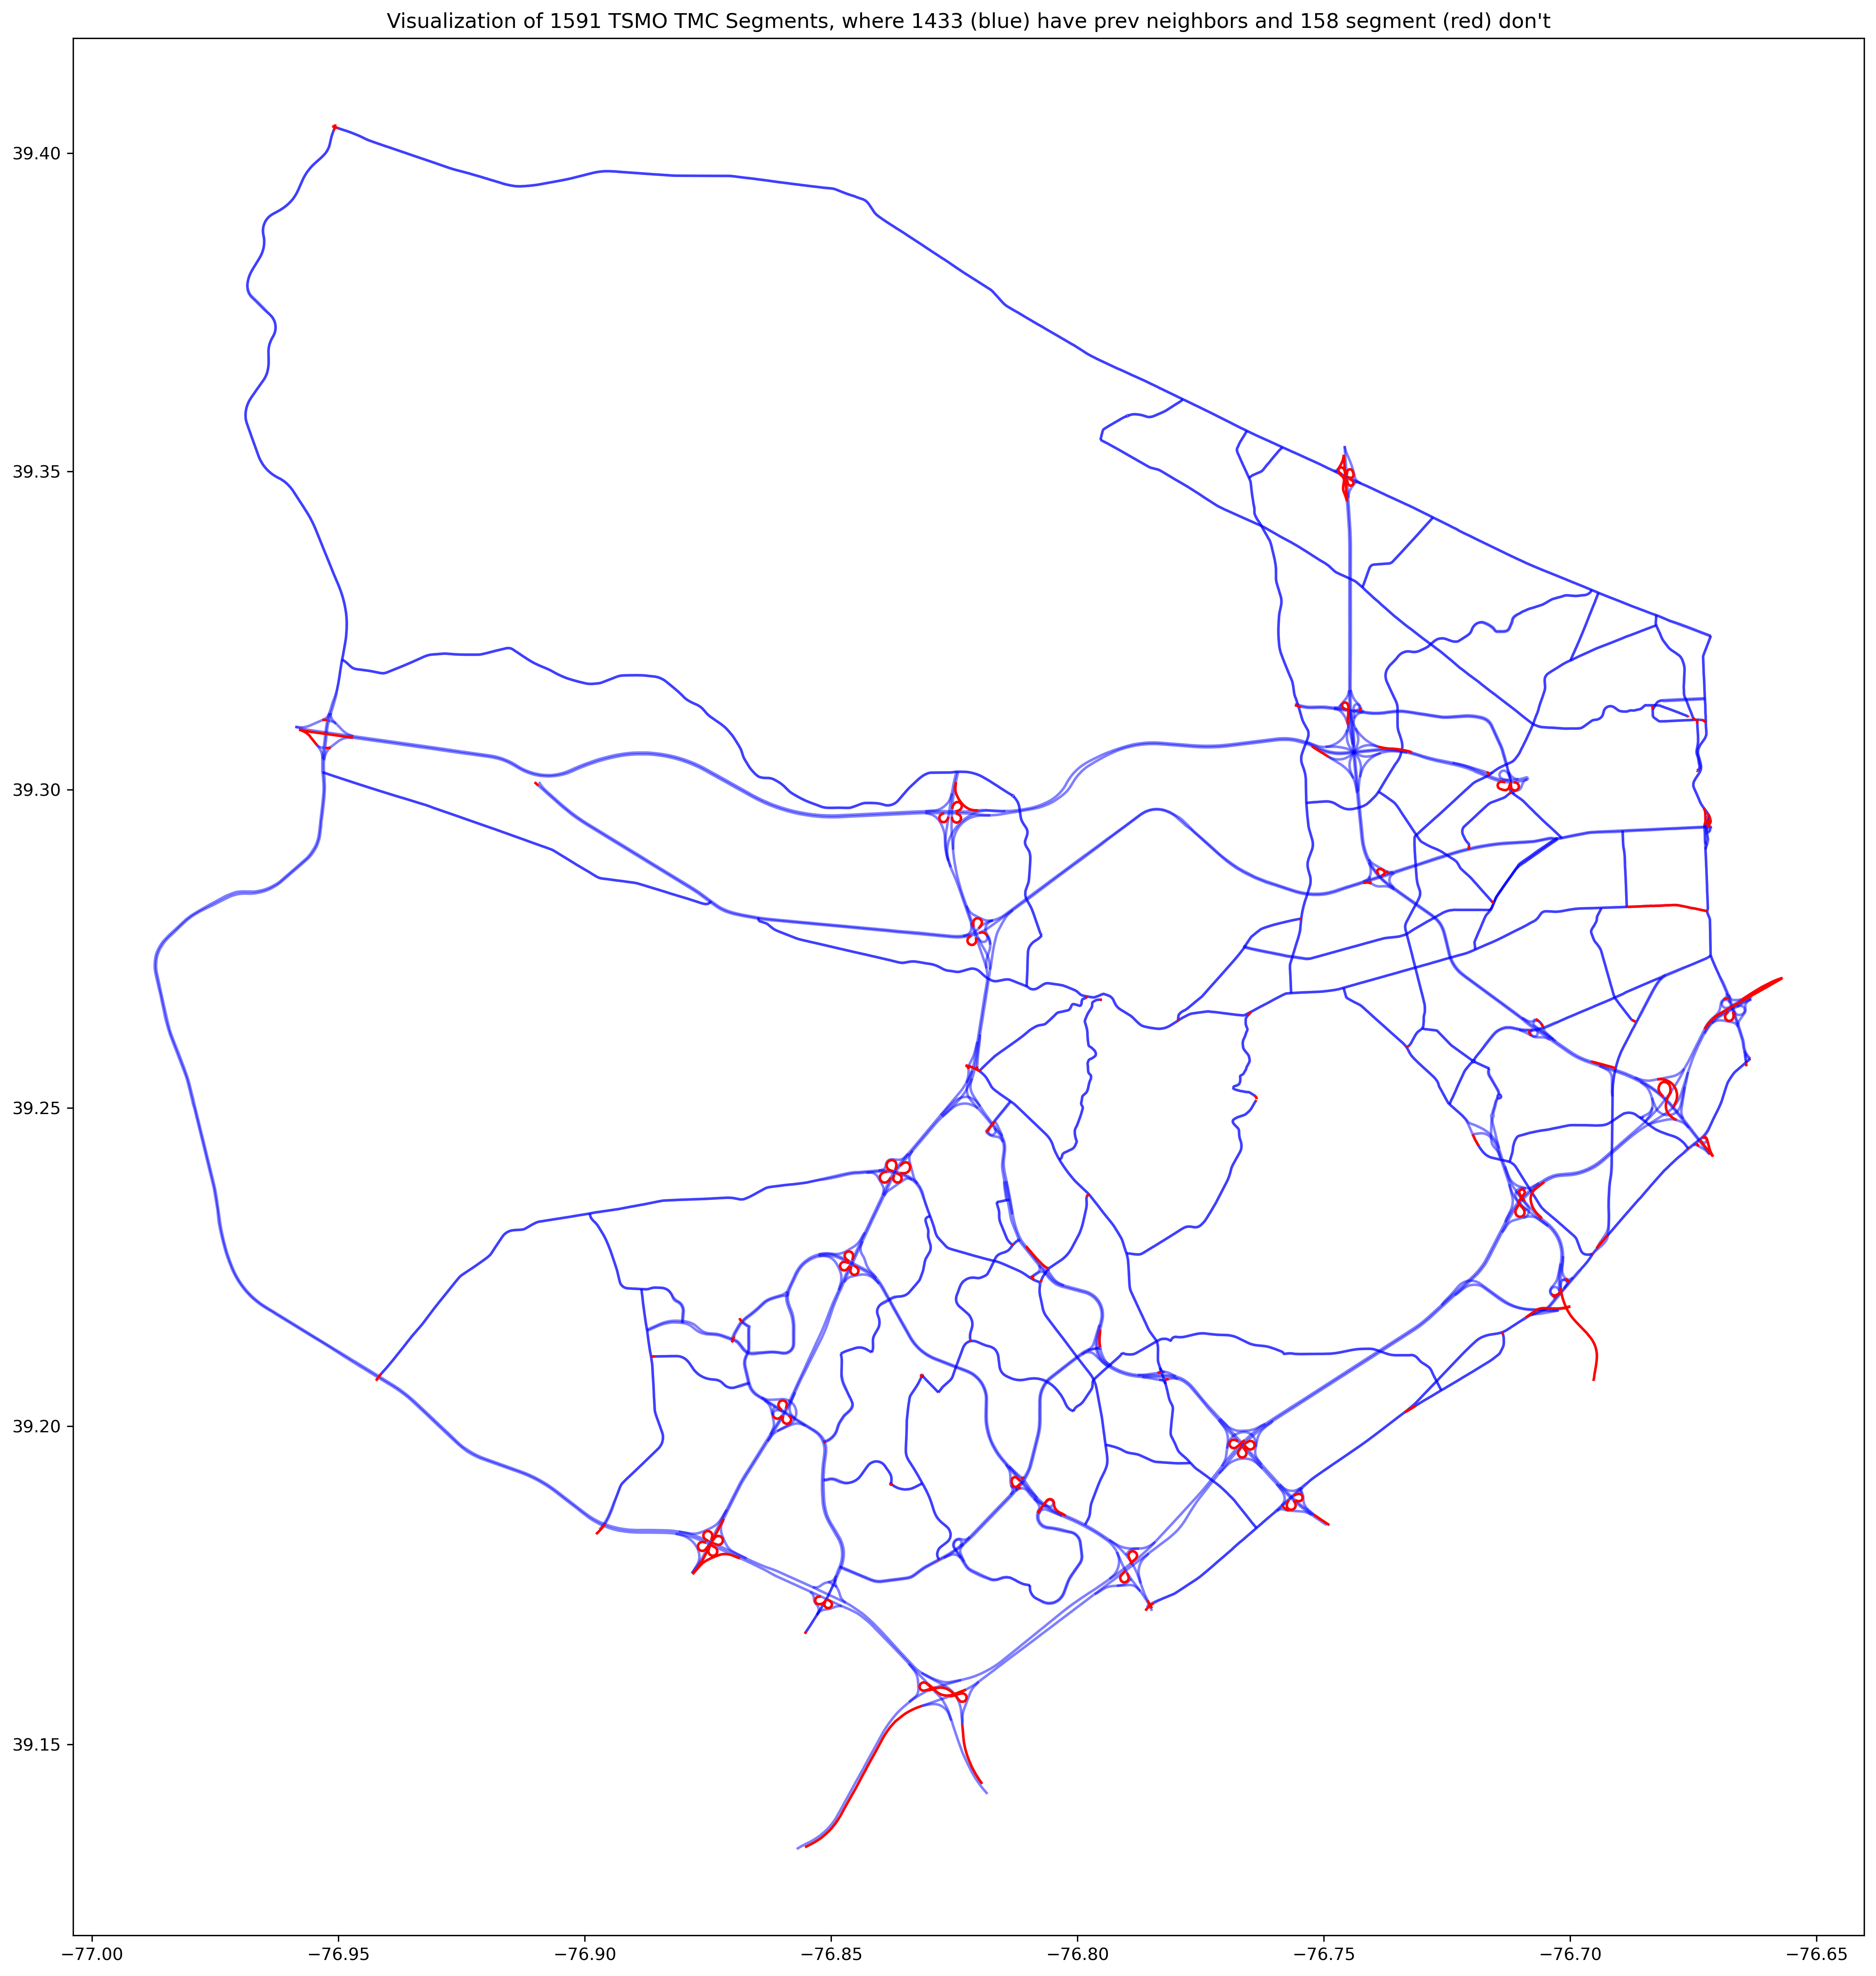

In [21]:
# Visualize and manually check segments without previous neighbors (There are 158 segments without any immediate prev neighbor)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 1591 TSMO TMC Segments, where 1433 (blue) have prev neighbors and 158 segment (red) don't")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(dict_prev_tmc)].plot(ax=ax, color="blue", alpha=0.5)
gdf_shp_tmc[(gdf_shp_tmc.id_tmc.isin(set_shp_tmc_segments)) & (~gdf_shp_tmc.id_tmc.isin(dict_prev_tmc))].plot(ax=ax, color="red")

In [38]:
set_tmc_segments_with_upstream = set(dict_prev_tmc.keys())  # 1433

In [41]:
f = open("./TSMO/TSMO_tmc_set_segments_with_upstream.txt", "w")
for i, k in enumerate(list(dict_prev_tmc.keys())):
    f.write(k)
    if i < len(dict_prev_tmc)-1:
        f.write(",")

In [36]:
pickle.dump(set_tmc_segments_with_upstream, open("./TSMO/TSMO_set_tmc_segments_with_upstream.pkl", "wb"))
pickle.dump(dict_prev_tmc, open("../data/TSMO/TSMO_dict_prev_tmc.pkl", "wb"))

### 1.3 Calculate upstream neighbors within certain range for each TMC segment using their immediate prev 

Calculate upstream neighbors without specifying range will easily break the limit of recursion depth. 

Therefore, here I specify a range of 5 miles and comupte the upstream within this range.

In [24]:
np.percentile(list(dict_miles_tmc.values()), 25), np.percentile(list(dict_miles_tmc.values()), 50), np.percentile(list(dict_miles_tmc.values()), 75)

(0.052897, 0.246173, 0.5614255)

In [25]:
# takes about 8 min to execute
dict_upstream_tmc_within_range = {}
for source in tqdm(list(set_shp_tmc_segments)):
    # dict_upstream_tmc[source] = compute_upstream(source=source, dict_prev=dict_prev_tmc, dict_upstream=dict_upstream_tmc)  # will break limit of recursion depth!!!
    dict_upstream_tmc_within_range[source] = compute_upstream_within_range(source=source, dict_prev=dict_prev_tmc, dict_upstream_within_range=dict_upstream_tmc_within_range, dict_miles=dict_miles_tmc, d=range)

100%|██████████| 1591/1591 [00:00<00:00, 1885.82it/s]


In [29]:
# convert dict of all upstream tuple to dict of unique upstream segments
dict_upstream_unique_tmc_5_miles = convert_dict_upstream_to_dict_upstream_set(dict_upstream_tmc_within_range, set_shp_tmc_segments)

100%|██████████| 1591/1591 [00:00<00:00, 95600.95it/s]


In [30]:
pickle.dump(dict_upstream_tmc_within_range, open("../data/TSMO/TSMO_dict_upstream_tmc_5_miles.pkl", "wb"))
pickle.dump(dict_upstream_unique_tmc_5_miles, open("../data/TSMO/TSMO_dict_upstream_unique_tmc_5_miles.pkl", "wb"))